In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from statsmodels.graphics import tsaplots
import seaborn as sns
import datetime

            cannonsville    pepacton   neversink    aggregate
datetime                                                     
1999-06-01    502.134336  489.175212  121.163156  1112.472704
1999-06-02    496.561406  501.923000   99.089110  1097.573516
1999-06-03    492.585911  501.923000    3.736817   998.245728
1999-06-04    492.635311  454.496824    6.416002   953.548138
1999-06-05     21.004342  370.664588    5.642724   397.311654
...                  ...         ...         ...          ...
2010-05-27    271.928673  197.731245    0.000000   469.659918
2010-05-28    295.638459  319.412174    0.000000   615.050632
2010-05-29    295.638459  345.103235    0.000000   640.741693
2010-05-30    295.638459  345.103235    0.000000   640.741693
2010-05-31    295.638459  345.103235    0.000000   640.741693

[4018 rows x 4 columns]


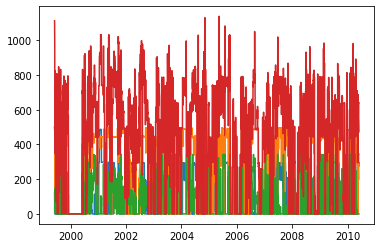

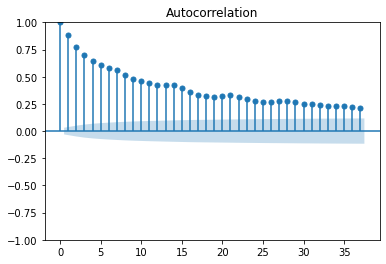

In [2]:
### read in NYC diversion data from WEAP - these look weird and dont match historical data from sharepoint exactly
nyc_WEAP = pd.read_csv('input_data/deliveryNYC_WEAP_23Aug2022_gridmet.csv', index_col=0)
nyc_WEAP.index = pd.to_datetime(nyc_WEAP.index)
# nyc_WEAP = nyc.loc[nyc.index >= datetime.datetime(2000,6,1)]

print(nyc_WEAP)

plt.plot(nyc_WEAP)

_ = tsaplots.plot_acf(nyc_WEAP['aggregate'])

In [3]:
nyc_WEAP.iloc[360:390]


,cannonsville,pepacton,neversink,aggregate
datetime,,,,
2000-05-26,0.000000,0.000000,0.000000,0.000000
2000-05-27,0.000000,0.000000,0.000000,0.000000
2000-05-28,0.000000,0.000000,0.000000,0.000000
2000-05-29,0.000000,0.000000,0.000000,0.000000
2000-05-30,0.000000,0.000000,0.000000,0.000000
2000-05-31,0.000000,0.000000,0.000000,0.000000
2000-06-01,188.848265,282.792928,237.290438,708.931631
2000-06-02,195.814163,403.451255,94.903337,694.168755
2000-06-03,295.638459,257.101867,138.424816,691.165142


            East Delaware Tunnel  West Delaware Tunnel  Neversink Tunnel  \
1999-12-01            399.000352            196.000173        105.000093   
1999-12-02            399.000352            196.000173         86.000076   
1999-12-03            357.000315             98.000086        118.000104   
1999-12-04            398.000351             99.000087          0.000000   
1999-12-05            398.000351             97.000086          0.000000   
...                          ...                   ...               ...   
2021-11-26            462.931582             92.986257        146.978278   
2021-11-27            462.931582              0.000000        147.978130   
2021-11-28            463.931434              0.000000          0.000000   
2021-11-29            462.931582              0.000000        109.983745   
2021-11-30            463.931434              0.000000        109.983745   

             aggregate  
1999-12-01  700.000617  
1999-12-02  681.000600  
1999-12-03  

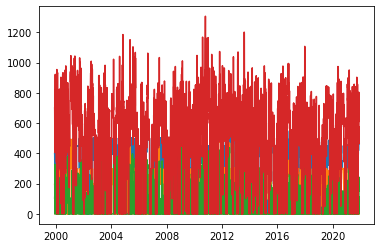

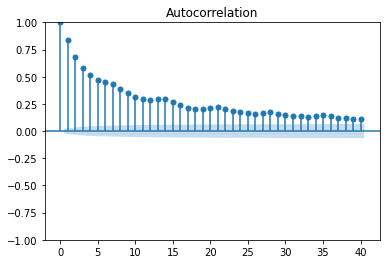

In [4]:
### read in historical NYC diversions from sharepoint
nyc = pd.read_excel('input_data/historical_diversions/Pep_Can_Nev_diversions_daily_2000-2021.xlsx', index_col=0)
nyc = nyc.iloc[:,:3]
nyc.index = pd.to_datetime(nyc.index)
nyc['aggregate'] = nyc.sum(axis=1)

### convert CFS to MGD
nyc *= 0.64631689

print(nyc)

plt.plot(nyc)

_ = tsaplots.plot_acf(nyc['aggregate'])

Text(0, 0.5, 'NYC deliveries (MGD)')

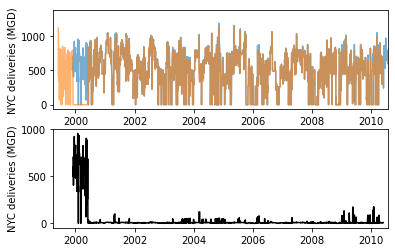

In [5]:
fig,axs=plt.subplots(2,1)
axs[0].plot(nyc['aggregate'], alpha=0.6)
axs[0].plot(nyc_WEAP['aggregate'], alpha=0.6)
axs[0].set_xlim([nyc_WEAP.index.min()-pd.Timedelta(60,'d'), nyc_WEAP.index.max()+pd.Timedelta(60,'d')])
axs[0].set_ylabel('NYC deliveries (MGD)')
axs[1].plot(nyc['aggregate'] - nyc_WEAP['aggregate'], color='k')
axs[1].set_xlim([nyc_WEAP.index.min(), nyc_WEAP.index.max()])
axs[1].set_xlim([nyc_WEAP.index.min()-pd.Timedelta(60,'d'), nyc_WEAP.index.max()+pd.Timedelta(60,'d')])
axs[1].set_ylabel('NYC deliveries (MGD)')


In [6]:
# stor = pd.read_csv('input_data/storageObs_WEAP_23Aug2022_gridmet.csv', index_col=0)
# stor.index = pd.to_datetime(stor.index)
# stor = stor.loc[stor.index >= datetime.datetime(2000,6,1)]
# plt.plot(stor)

# stor['aggregate'] = stor['cannonsville'] + stor['pepacton'] + stor['neversink']



In [7]:
### read in total gaged flow to NYC reservoirs
flow = pd.read_csv('input_data/catchment_inflow_obs_pub.csv', index_col=0)

flow.index = pd.to_datetime(flow.index)
flow = flow.loc[np.logical_and(flow.index >= nyc.index.min(), flow.index <= nyc.index.max())]
nyc = nyc.loc[np.logical_and(nyc.index >= flow.index.min(), nyc.index <= flow.index.max())]

assert np.all(flow.index == nyc.index)

In [8]:
### build dataframe 
df = pd.DataFrame({'nyc':nyc['aggregate'], 'flow_log':np.log(flow[['cannonsville','pepacton','neversink']].sum(axis=1)), 'm':nyc.index.month}, index=nyc.index)


In [9]:
# ### build ARIMA model of normalized nyc deliveries with month and normalized log flow as exogenous predictors
# df = pd.DataFrame({'nyc':nyc['aggregate'], 'flow_log':np.log(flow[['cannonsville','pepacton','neversink']].sum(axis=1)), 'm':nyc.index.month}, index=nyc.index)

# # ### whiten deliveries & log flow by month
# df['nyc_norm'] = 0.
# nyc_means = {}
# nyc_stds = {}
# for m in range(1,13):
#     nyc_means[m] = df['nyc'].loc[df['m'] == m].mean()
#     nyc_stds[m] = df['nyc'].loc[df['m'] == m].std()
#     df['nyc_norm'].loc[df['m'] == m] = (df['nyc'].loc[df['m'] == m] - nyc_means[m]) / nyc_stds[m]
# df['flow_log_norm'] = 0.
# flow_means = {}
# flow_stds = {}
# for m in range(1,13):
#     flow_means[m] = df['flow_log'].loc[df['m'] == m].mean()
#     flow_stds[m] = df['flow_log'].loc[df['m'] == m].std()
#     df['flow_log_norm'].loc[df['m'] == m] = (df['flow_log'].loc[df['m'] == m] - flow_means[m]) / flow_stds[m]

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].plot(df['nyc'])
# axs[1].plot(df['nyc_norm'])

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _ = tsaplots.plot_acf(df['nyc_norm'], ax=axs[0])
# _ = tsaplots.plot_pacf(df['nyc_norm'], ax=axs[1])

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].plot(df['flow_log'])
# axs[1].plot(df['flow_log_norm'])

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _ = tsaplots.plot_acf(df['flow_log_norm'], ax=axs[0])
# _ = tsaplots.plot_pacf(df['flow_log_norm'], ax=axs[1])

# sns.pairplot(df)



In [10]:
# ### difference the model to improve ARMA fit (ie ARIMA with d=1)

# # ### whiten deliveries & log flow by month
# df['nyc_norm_diff'] = 0.
# df['nyc_norm_diff'].iloc[1:] = df['nyc_norm'].iloc[1:] - df['nyc_norm'].iloc[:-1].values

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].plot(df['nyc'])
# axs[1].plot(df['nyc_norm_diff'])

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _ = tsaplots.plot_acf(df['nyc_norm_diff'], ax=axs[0])
# _ = tsaplots.plot_pacf(df['nyc_norm_diff'], ax=axs[1])






In [11]:
# ### fit arima model now (remember we already differenced)
# from statsmodels.tsa.arima.model import ARIMA

# # arima_mod = ARIMA(df['nyc_norm'], exog=df[['m','flow_log_norm']], order=(3,1,3), seasonal_order=(1,0,1,7))
# # arima_mod = ARIMA(df['nyc_norm_diff'], exog=df[['flow_log_norm']], order=(2,0,1), seasonal_order=(1,0,1,7))
# # arima_mod = ARIMA(df['nyc_norm_diff'], order=(2,0,1), seasonal_order=(1,0,1,7))
# arima_mod = ARIMA(df['nyc_norm_diff'], exog=df[['flow_log_norm']], order=(3,0,0), seasonal_order=(1,0,0,7))


# arima_res = arima_mod.fit()
# print(arima_res.summary())

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _= tsaplots.plot_acf(arima_res.resid, ax=axs[0])
# _= tsaplots.plot_pacf(arima_res.resid, ax=axs[1])

In [12]:
# ### now try simulating alternative diversion scenarios from fitted arima. note I was getting weird results with "simulate" above.

# ### first resample residuals from empirical residuals
# resid_samp = np.random.choice(arima_res.resid, size=len(arima_res.resid), replace=True)

# ### now simulate ARMA process
# df['nyc_norm_diff_pred'] = df['nyc_norm_diff']

# for i in range(7, df.shape[0]):
#     zero_norm = -nyc_means[df['m'].iloc[i]]/nyc_stds[df['m'].iloc[i]]
# #     df['nyc_norm_pred'].iloc[i] = max(arima_res.params[0] + \
# #                                       arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
# #                                       arima_res.params[2] * df['nyc_norm_pred'].iloc[i-1] + \
# #                                       arima_res.params[3] * df['nyc_norm_pred'].iloc[i-2] + \
# #                                       arima_res.params[4] * df['nyc_norm_pred'].iloc[i-3] + \
# #                                       arima_res.params[5] * resid_samp[i-1] + \
# #                                       arima_res.params[6] * df['nyc_norm_pred'].iloc[i-7] + \
# #                                       arima_res.params[7] * resid_samp[i-7] + \
# #                                       resid_samp[i], 
# #                                       zero_norm)

# #     df['nyc_norm_diff_pred'].iloc[i] = arima_res.params[0] + \
# #                                       arima_res.params[1] * df['nyc_norm_diff_pred'].iloc[i-1] + \
# #                                       arima_res.params[2] * df['nyc_norm_diff_pred'].iloc[i-2] + \
# #                                       arima_res.params[3] * resid_samp[i-1] + \
# #                                       arima_res.params[4] * df['nyc_norm_diff_pred'].iloc[i-7] + \
# #                                       arima_res.params[5] * resid_samp[i-7] + \
# #                                       resid_samp[i]

#     df['nyc_norm_diff_pred'].iloc[i] = max(arima_res.params[0] + \
#                                       arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
#                                       arima_res.params[2] * df['nyc_norm_diff_pred'].iloc[i-1] + \
#                                       arima_res.params[3] * df['nyc_norm_diff_pred'].iloc[i-2] + \
#                                       arima_res.params[4] * df['nyc_norm_diff_pred'].iloc[i-3] + \
#                                       arima_res.params[5] * df['nyc_norm_diff_pred'].iloc[i-7] + \
#                                       resid_samp[i], 
#                                       zero_norm)

# # ### apply integration, but dont allow to drop below 0
# df['nyc_norm_pred'] = 0.
# df['nyc_norm_pred'].iloc[0] = df['nyc_norm'].iloc[0]
# for i in range(1,df.shape[0]):
#     zero_norm = -nyc_means[df['m'].iloc[i]]/nyc_stds[df['m'].iloc[i]]
#     df['nyc_norm_pred'].iloc[i] = max(df['nyc_norm_pred'].iloc[i-1] + df['nyc_norm_diff_pred'].iloc[i], zero_norm)


# ### rescale
# df['nyc_pred'] = [v * nyc_stds[m] + nyc_means[m] for v,m in zip(df['nyc_norm_pred'],df['m'])]

In [13]:
# df

In [14]:
# ### compare predicted & observed deliveries
# alpha=0.7
# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'], alpha=alpha)
# plt.plot(df['nyc_pred'], alpha=alpha)
# plt.legend()

# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'].rolling(30).mean(), alpha=alpha)
# plt.plot(df['nyc_pred'].rolling(30).mean(), alpha=alpha)
# plt.legend()

In [15]:
# ### retry with no differencing, something weird was happening
# from statsmodels.tsa.arima.model import ARIMA

# # arima_mod = ARIMA(df['nyc_norm'], exog=df['flow_log_norm'], order=(2,0,1), seasonal_order=(1,0,1,7))
# arima_mod = ARIMA(df['nyc_norm'], exog=df['flow_log_norm'], order=(3,0,0), seasonal_order=(1,0,0,7))



# arima_res = arima_mod.fit()
# print(arima_res.summary())

# fig, axs = plt.subplots(1,2,figsize=(12,6))
# _= tsaplots.plot_acf(arima_res.resid, ax=axs[0])
# _= tsaplots.plot_pacf(arima_res.resid, ax=axs[1])

In [16]:
# arima_res.params

In [17]:
# ### now try simulating alternative diversion scenarios from fitted arima. note I was getting weird results with "simulate" above.

# ### first resample residuals from empirical residuals
# resid_samp = np.random.choice(arima_res.resid, size=len(arima_res.resid), replace=True)
# # resid_samp = np.random.normal(0, np.sqrt(arima_res.params[-1]), size=len(arima_res.resid))


# ### now simulate ARMA process
# df['nyc_norm_pred'] = df['nyc_norm']

# for i in range(7, df.shape[0]):
#     zero_norm = -nyc_means[df['m'].iloc[i]]/nyc_stds[df['m'].iloc[i]]
# #     df['nyc_norm_pred'].iloc[i] = max(arima_res.params[0] + \
# #                                       arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
# #                                       arima_res.params[2] * df['nyc_norm_pred'].iloc[i-1] + \
# #                                       arima_res.params[3] * df['nyc_norm_pred'].iloc[i-2] + \
# #                                       arima_res.params[4] * resid_samp[i-1] + \
# #                                       arima_res.params[5] * df['nyc_norm_pred'].iloc[i-7] + \
# #                                       arima_res.params[6] * resid_samp[i-7] + \
# #                                       resid_samp[i], 
# #                                       zero_norm)
    
#     df['nyc_norm_pred'].iloc[i] = max(arima_res.params[0] + \
#                                   arima_res.params[1] * df['flow_log_norm'].iloc[i] + \
#                                   arima_res.params[2] * df['nyc_norm_pred'].iloc[i-1] + \
#                                   arima_res.params[3] * df['nyc_norm_pred'].iloc[i-2] + \
#                                   arima_res.params[4] * df['nyc_norm_pred'].iloc[i-3] + \
#                                   arima_res.params[5] * df['nyc_norm_pred'].iloc[i-7] + \
#                                   resid_samp[i], 
#                                   zero_norm)


# ### rescale
# df['nyc_pred'] = [v * nyc_stds[m] + nyc_means[m] for v,m in zip(df['nyc_norm_pred'],df['m'])]

In [18]:
# df.iloc[:20]

In [19]:
# ### compare predicted & observed deliveries
# alpha=0.7
# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'], alpha=alpha)
# plt.plot(df['nyc_pred'], alpha=alpha)
# plt.legend()

# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'].rolling(30).mean(), alpha=alpha)
# plt.plot(df['nyc_pred'].rolling(30).mean(), alpha=alpha)
# plt.legend()

# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'].iloc[:365], alpha=alpha)
# plt.plot(df['nyc_pred'].iloc[:365], alpha=alpha)
# plt.legend()

# plt.figure(figsize=(12,5))
# plt.plot(df['nyc'].iloc[:365].rolling(30).mean(), alpha=alpha)
# plt.plot(df['nyc_pred'].iloc[:365].rolling(30).mean(), alpha=alpha)
# plt.legend()

In [20]:
# sns.pairplot(df, vars=['m','flow_log_norm','nyc','nyc_pred'])

### Try bootstrapping version instead, since AR model tends to produce too high of values

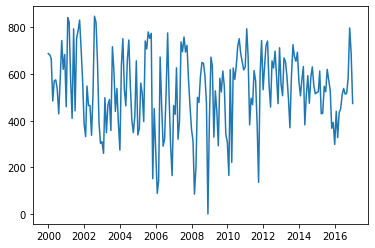

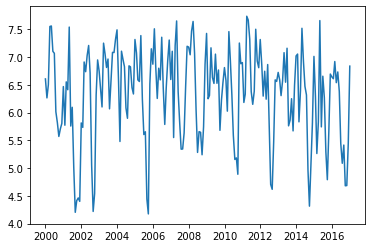

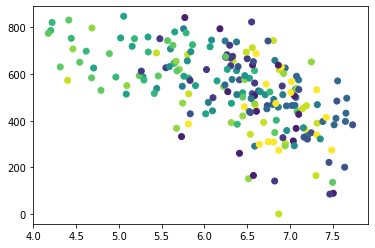

In [21]:
df = df[['nyc','flow_log','m']]
df_m = df.resample('m').mean()

plt.figure()
plt.plot(df_m['nyc'])

plt.figure()
plt.plot(df_m['flow_log'])

plt.figure()
plt.scatter(df_m['flow_log'], df_m['nyc'], color=cm.get_cmap('viridis')(df_m['m']/12))

/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

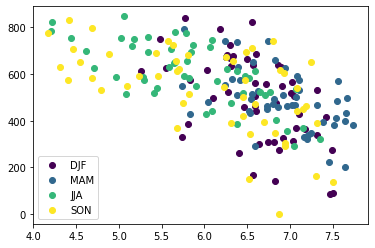

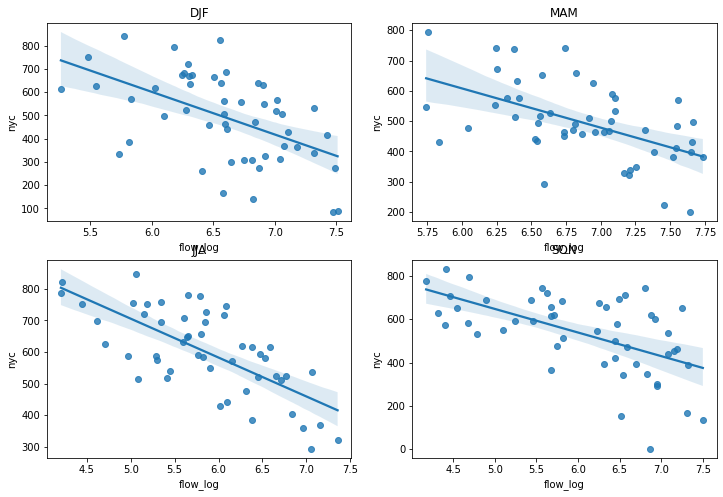

In [22]:
### separate scatterplot by quarter
def get_quarter(m):
    if m in (12,1,2):
        return 'DJF'
    elif m in (3,4,5):
        return 'MAM'
    elif m in (6,7,8):
        return 'JJA'
    elif m in (9,10,11):
        return 'SON'
df_m['quarter'] = [get_quarter(m) for m in df_m['m']]
quarters = ('DJF','MAM','JJA','SON')
plt.figure()
for i,q in enumerate(quarters):
    plt.scatter(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nyc'].loc[df_m['quarter'] == q],
                color=cm.get_cmap('viridis')(i/3), label=q)
plt.legend()

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nyc'].loc[df_m['quarter'] == q], ax=ax)
    ax.set_title(q)

In [23]:
### get linear regression model for each quarter
import statsmodels.api as sm

lrms = {q: sm.OLS(df_m['nyc'].loc[df_m['quarter'] == q], 
                  sm.add_constant(df_m['flow_log'].loc[df_m['quarter'] == q])) for q in quarters}
lrrs = {q: lrms[q].fit() for q in quarters}
for q,lrr in lrrs.items():
    print(q)
    print(lrr.summary())

DJF
                            OLS Regression Results                            
Dep. Variable:                    nyc   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     19.03
Date:                Thu, 13 Apr 2023   Prob (F-statistic):           6.43e-05
Time:                        14:07:15   Log-Likelihood:                -336.92
No. Observations:                  52   AIC:                             677.8
Df Residuals:                      50   BIC:                             681.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1704.7608    278.792      6.115     

<AxesSubplot:xlabel='flow_log', ylabel='Density'>

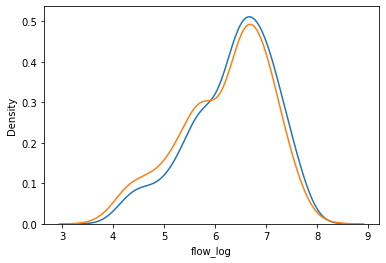

In [24]:
### now get longer dataset of flows for prediction
flow = pd.read_csv('input_data/catchment_inflow_obs_pub.csv', index_col=0)

flow.index = pd.to_datetime(flow.index)

df_long = pd.DataFrame({'flow_log':np.log(flow[['cannonsville','pepacton','neversink']].sum(axis=1)), 'm':flow.index.month})
df_long_m = df_long.resample('m').mean()
df_long_m['quarter'] = [get_quarter(m) for m in df_long_m['m']]

sns.kdeplot(df_m['flow_log'])
sns.kdeplot(df_long_m['flow_log'])

In [25]:
### use trained regression model to sample an nyc delivery value for each month based on log flow. 
df_long_m['nyc_pred'] = 0.
for i in range(df_long_m.shape[0]):
    q = df_long_m['quarter'].iloc[i]
    f = df_long_m['flow_log'].iloc[i]
    lrm = lrms[q]
    lrr = lrrs[q]
    exog = lrm.exog
    exog[:, 1] = f
    ### get randomly sampled value from linear regression model. thrown out if negative
    pred = -1
    while pred < 0:
        pred = lrm.get_distribution(lrr.params, scale=np.var(lrr.resid), exog=exog).rvs()[0]
    df_long_m['nyc_pred'].iloc[i] = pred

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

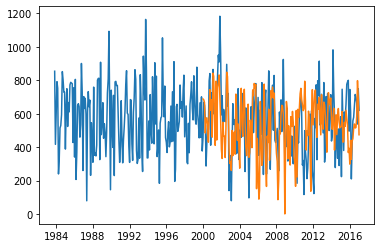

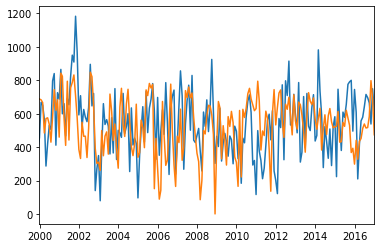

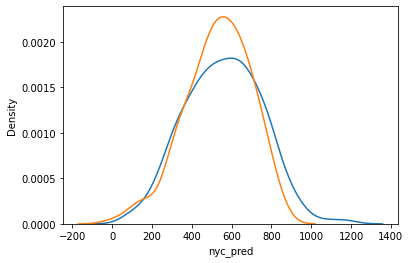

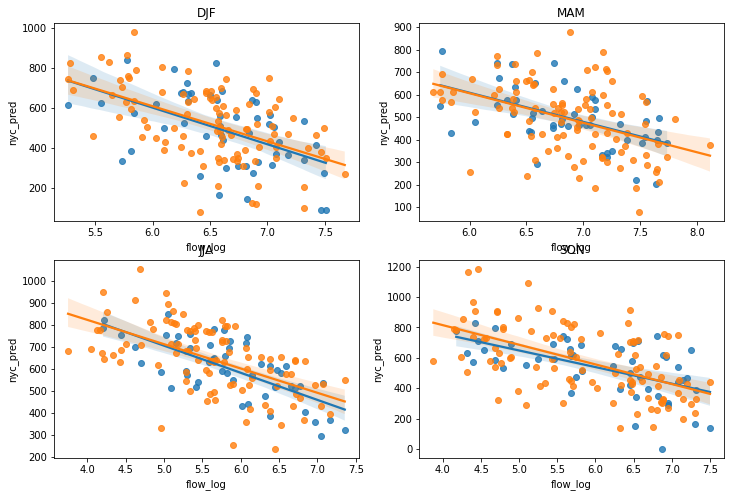

In [26]:
### viz results
plt.figure()
plt.plot(df_long_m['nyc_pred'])
plt.plot(df_m['nyc'])

plt.figure()
plt.plot(df_long_m['nyc_pred'])
plt.plot(df_m['nyc'])
plt.xlim([df_m['nyc'].index.min(), df_m['nyc'].index.max()])

plt.figure()
sns.kdeplot(df_long_m['nyc_pred'])
sns.kdeplot(df_m['nyc'])

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nyc'].loc[df_m['quarter'] == q], ax=ax)
    sns.regplot(df_long_m['flow_log'].loc[df_long_m['quarter'] == q], df_long_m['nyc_pred'].loc[df_long_m['quarter'] == q], ax=ax)
    ax.set_title(q)

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

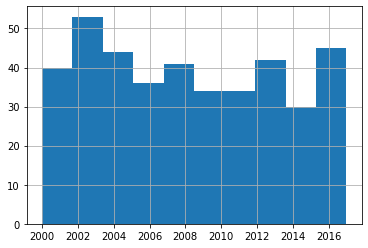

In [27]:
### now get nearest neighbor in normalized 2d space of log-flow/nyc, within q.
flow_bounds = [df_m['flow_log'].min(), df_m['flow_log'].max()]
nyc_bounds = [df_m['nyc'].min(), df_m['nyc'].max()]

df_m['flow_log_norm'] = (df_m['flow_log'] - flow_bounds[0]) / (flow_bounds[1] - flow_bounds[0])
df_m['nyc_norm'] = (df_m['nyc'] - nyc_bounds[0]) / (nyc_bounds[1] - nyc_bounds[0])
df_long_m['flow_log_norm'] = (df_long_m['flow_log'] - flow_bounds[0]) / (flow_bounds[1] - flow_bounds[0])
df_long_m['nyc_pred_norm'] = (df_long_m['nyc_pred'] - nyc_bounds[0]) / (nyc_bounds[1] - nyc_bounds[0])


df_long_m['nn'] = -1
for i in range(df_long_m.shape[0]):
    q = df_long_m['quarter'].iloc[i]
    f = df_long_m['flow_log_norm'].iloc[i]
    n = df_long_m['nyc_pred_norm'].iloc[i]
    df_m_sub = df_m.loc[df_m['quarter'] == q]
    dist_squ = (f - df_m_sub['flow_log_norm']) **2 + (n - df_m_sub['nyc_norm']) **2
    nn = np.argmin(dist_squ)
    df_long_m['nn'].iloc[i] = df_m_sub.index[nn]
df_long_m['nn'].hist()

In [28]:
### now use each month's nearest neighbor to get flow shape for nyc_pred at daily time step
df_long['y'] = df_long.index.year
df_long_m['y'] = df_long_m.index.year
df['y'] = df.index.year
df_m['y'] = df_m.index.year
df['quarter'] = [get_quarter(m) for m in df['m']]
df_long['quarter'] = [get_quarter(m) for m in df_long['m']]

### iterate over months in longer record
df_long['nyc_pred'] = -1
for i,row in df_long_m.iterrows():
    m = row['m']
    y = row['y']
    ### get the nyc deliveries in nearest neighbor from shorter record
    df_long_idx = df_long.loc[np.logical_and(df_long['m'] == m, df_long['y'] == y)].index
    df_m_match = df_m.loc[row['nn']]
    df_match = df.loc[np.logical_and(df['m'] == df_m_match['m'], df['y'] == df_m_match['y'])]
    ### scale daily nyc deliveries based on ratio of monthly prediction to match
    new_nyc = df_match['nyc'].values * row['nyc_pred'] / df_m_match['nyc']
    if np.any(new_nyc < 0):
        print(row, new_nyc)
    ### adjust based on length of month
    len_new = len(df_long_idx)
    len_match = len(new_nyc)
    if len_match > len_new:
        new_nyc = new_nyc[:len_new]
    elif len_match < len_new:
        new_nyc = np.append(new_nyc, [new_nyc[-1]]*(len_new - len_match))
    df_long['nyc_pred'].loc[df_long_idx] = new_nyc

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [29]:
df_long

,flow_log,m,y,quarter,nyc_pred
datetime,,,,,
1983-10-01,3.939473,10,1983,SON,706.372386
1983-10-02,3.977106,10,1983,SON,703.292273
1983-10-03,3.911809,10,1983,SON,567.767339
1983-10-04,3.898274,10,1983,SON,774.134853
1983-10-05,3.934305,10,1983,SON,754.627476
...,...,...,...,...,...
2016-12-27,6.978394,12,2016,DJF,655.188196
2016-12-28,6.993512,12,2016,DJF,1092.964093
2016-12-29,6.821047,12,2016,DJF,1138.217332


/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

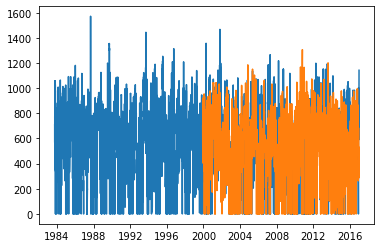

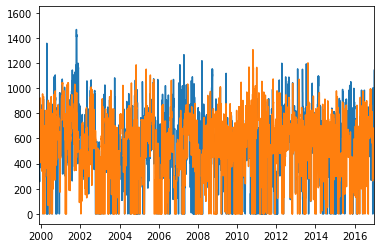

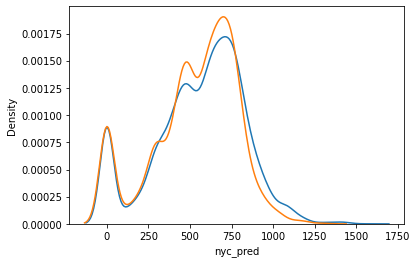

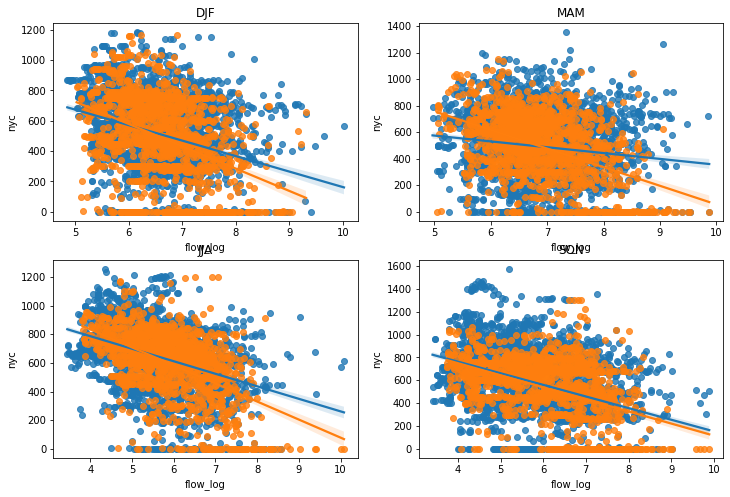

In [30]:
### viz results
plt.figure()
plt.plot(df_long['nyc_pred'])
plt.plot(df['nyc'])

plt.figure()
plt.plot(df_long['nyc_pred'])
plt.plot(df['nyc'])
plt.xlim([df['nyc'].index.min(), df_m['nyc'].index.max()])

plt.figure()
sns.kdeplot(df_long['nyc_pred'])
sns.kdeplot(df['nyc'])

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_long['flow_log'].loc[df_long['quarter'] == q], df_long['nyc_pred'].loc[df_long['quarter'] == q], ax=ax)
    sns.regplot(df['flow_log'].loc[df['quarter'] == q], df['nyc'].loc[df['quarter'] == q], ax=ax)
    ax.set_title(q)

In [31]:
### Ok now reload full NYC data, & replace predicted with actual data for time periods we have
nyc = pd.read_excel('input_data/historical_diversions/Pep_Can_Nev_diversions_daily_2000-2021.xlsx', index_col=0)
nyc = nyc.iloc[:,:3]
nyc.index = pd.to_datetime(nyc.index)
nyc['aggregate'] = nyc.sum(axis=1)
### convert CFS to MGD
nyc *= 0.64631689

df_long = df_long.loc[df_long.index < nyc.index.min()]
nyc = nyc.append(pd.DataFrame({'aggregate': df_long['nyc_pred']}))
nyc = nyc.sort_index()
nyc['datetime'] = nyc.index
nyc.columns = ['pepacton','cannonsville','neversink','aggregate', 'datetime']
nyc = nyc.iloc[:, [-1,1,0,2,3]]
nyc.to_csv('input_data/deliveryNYC_ODRM_extrapolated.csv', index=False)
nyc

,datetime,cannonsville,pepacton,neversink,aggregate
1983-10-01,1983-10-01,NaN,NaN,NaN,706.372386
1983-10-02,1983-10-02,NaN,NaN,NaN,703.292273
1983-10-03,1983-10-03,NaN,NaN,NaN,567.767339
1983-10-04,1983-10-04,NaN,NaN,NaN,774.134853
1983-10-05,1983-10-05,NaN,NaN,NaN,754.627476
...,...,...,...,...,...
2021-11-26,2021-11-26,92.986257,462.931582,146.978278,702.896117
2021-11-27,2021-11-27,0.000000,462.931582,147.978130,610.909712
2021-11-28,2021-11-28,0.000000,463.931434,0.000000,463.931434
2021-11-29,2021-11-29,0.000000,462.931582,109.983745,572.915327


### repeat for NJ

,D_R_Canal
datetime,
1990-08-01,93.014261
1990-08-02,96.243923
1990-08-03,99.473585
1990-08-04,97.535788
1990-08-05,96.243923
...,...
2022-05-28,67.176966
2022-05-29,94.952058
2022-05-30,97.535788


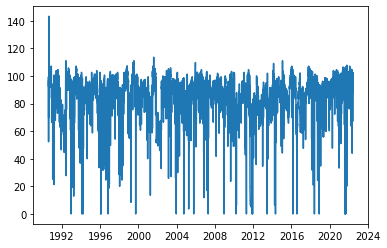

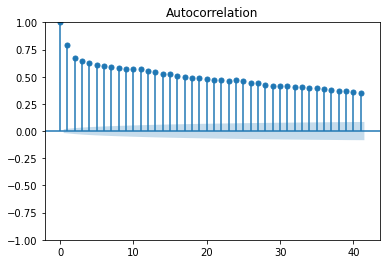

In [32]:
### read in NJ diversion data form WEAP - note need to verify source
nj = pd.read_csv('input_data/deliveryNJ_WEAP_23Aug2022_gridmet.csv', index_col=0)
nj.index = pd.to_datetime(nj.index)
plt.plot(nj)

_ = tsaplots.plot_acf(nj['D_R_Canal'])

nj

In [33]:
### read in total gaged flow to NYC reservoirs
flow = pd.read_csv('input_data/catchment_inflow_obs_pub.csv', index_col=0)

flow.index = pd.to_datetime(flow.index)
flow = flow.loc[np.logical_and(flow.index >= nj.index.min(), flow.index <= nj.index.max())]
nj = nj.loc[np.logical_and(nj.index >= flow.index.min(), nj.index <= flow.index.max())]

assert np.all(flow.index == nj.index)

flow

,cannonsville,pepacton,neversink,wallenpaupack,prompton,shoholaMarsh,mongaupeCombined,beltzvilleCombined,fewalter,merrillCreek,...,01433500,delMontague,01449800,01447800,delTrenton,01463620,outletAssunpink,01470960,outletSchuylkill,outletChristina
datetime,,,,,,,,,,,,,,,,,,,,,
1990-08-01,72.373329,42.907045,30.370951,NaN,15.508571,NaN,NaN,33.601903,103.390470,NaN,...,24.555237,1090.769461,9.046666,31.017141,1283.334212,0.0,0.0,77.542853,510.490447,5.621857
1990-08-02,67.849996,36.703617,27.786189,NaN,16.800951,NaN,NaN,27.139998,100.159518,NaN,...,208.719512,904.020424,20.678094,34.894284,1574.766100,0.0,0.0,73.019520,450.911688,5.040285
1990-08-03,58.157140,33.214189,27.139998,NaN,16.154761,NaN,NaN,25.201427,93.051423,NaN,...,199.026655,380.606169,10.985237,42.002379,1418.388014,0.0,0.0,62.034282,478.374782,4.652571
1990-08-04,52.987616,30.823284,25.201427,NaN,16.154761,NaN,NaN,24.555237,89.820471,NaN,...,202.257607,297.893792,6.461904,45.233331,1442.943251,0.0,0.0,54.926187,387.972740,4.394095
1990-08-05,58.157140,45.233331,37.479045,NaN,42.002379,NaN,NaN,36.832855,120.191422,NaN,...,25.201427,652.006153,0.000000,14.862380,1301.427545,0.0,0.0,55.572378,430.362833,4.523333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,553.785206,401.801215,117.606660,69.110707,120.837612,45.318446,180.418942,26.558427,153.147134,27.574981,...,0.000000,688.007564,0.000000,31.663332,1333.959759,0.0,0.0,0.000000,538.688366,6.448477
2016-12-28,597.079966,369.685550,122.776183,86.646523,100.159518,59.329531,162.991248,26.170713,182.225704,27.091207,...,0.000000,695.858831,0.000000,72.373329,935.570729,0.0,0.0,8.770601,449.953942,8.606782
2016-12-29,488.519972,323.095220,105.329042,103.275465,69.142377,62.043607,160.652966,26.364570,182.225704,40.523228,...,0.000000,1095.646928,0.000000,111.144756,721.095390,0.0,0.0,0.000000,507.341999,9.557030


In [34]:
flow.columns

Index(['cannonsville', 'pepacton', 'neversink', 'wallenpaupack', 'prompton',
       'shoholaMarsh', 'mongaupeCombined', 'beltzvilleCombined', 'fewalter',
       'merrillCreek', 'hopatcong', 'nockamixon', 'assunpink', 'ontelaunee',
       'stillCreek', 'blueMarsh', 'greenLane', 'marshCreek', '01425000',
       '01417000', 'delLordville', '01436000', '01433500', 'delMontague',
       '01449800', '01447800', 'delTrenton', '01463620', 'outletAssunpink',
       '01470960', 'outletSchuylkill', 'outletChristina'],
      dtype='object')

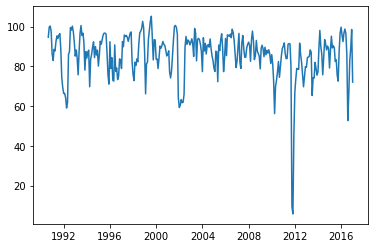

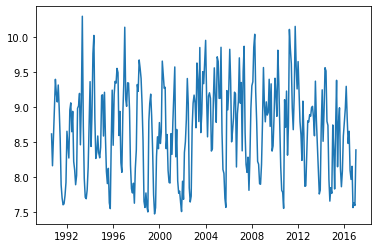

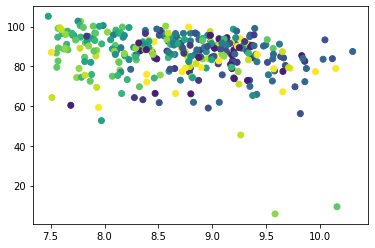

In [35]:
# df = pd.DataFrame({'nj':nj['D_R_Canal'], 'flow_log':np.log(flow[['cannonsville','pepacton','neversink']].sum(axis=1)), 'm':nj.index.month}, index=nj.index)

trenton_catchments = ['cannonsville', 'pepacton', '01425000', '01417000', 'delLordville', 'prompton', 'wallenpaupack', \
                      'shoholaMarsh', 'mongaupeCombined', 'neversink', '01436000', '01433500', 'delMontague', 'beltzvilleCombined',\
                       'fewalter', 'merrillCreek', 'hopatcong', 'nockamixon', '01449800', '01447800', 'delTrenton']
df = pd.DataFrame({'nj':nj['D_R_Canal'], 'flow_log':np.log(flow[trenton_catchments].sum(axis=1)), 'm':nj.index.month}, index=nj.index)

df_m = df.resample('m').mean()

plt.figure()
plt.plot(df_m['nj'])

plt.figure()
plt.plot(df_m['flow_log'])

plt.figure()
plt.scatter(df_m['flow_log'], df_m['nj'], color=cm.get_cmap('viridis')(df_m['m']/12))

/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

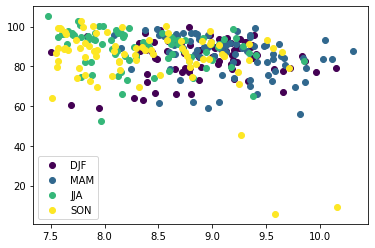

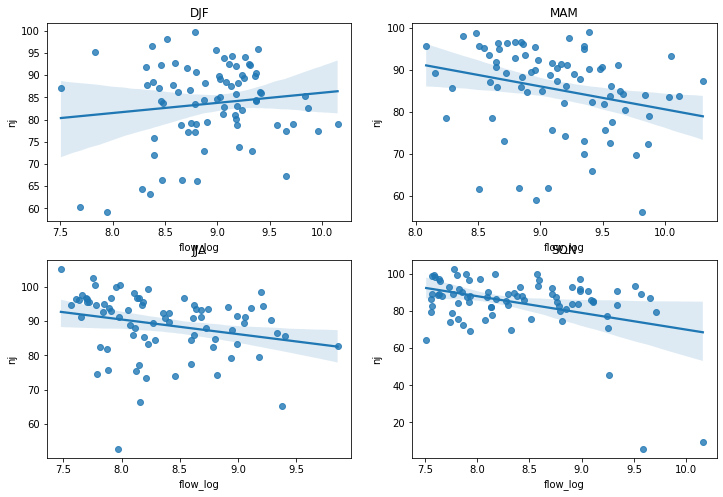

In [36]:
### separate scatterplot by quarter
def get_quarter(m):
    if m in (12,1,2):
        return 'DJF'
    elif m in (3,4,5):
        return 'MAM'
    elif m in (6,7,8):
        return 'JJA'
    elif m in (9,10,11):
        return 'SON'
df_m['quarter'] = [get_quarter(m) for m in df_m['m']]
quarters = ('DJF','MAM','JJA','SON')
plt.figure()
for i,q in enumerate(quarters):
    plt.scatter(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nj'].loc[df_m['quarter'] == q],
                color=cm.get_cmap('viridis')(i/3), label=q)
plt.legend()

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nj'].loc[df_m['quarter'] == q], ax=ax)
    ax.set_title(q)
    

In [37]:
### get linear regression model for each quarter
import statsmodels.api as sm

lrms = {q: sm.OLS(df_m['nj'].loc[df_m['quarter'] == q], 
                  sm.add_constant(df_m['flow_log'].loc[df_m['quarter'] == q])) for q in quarters}
lrrs = {q: lrms[q].fit() for q in quarters}
for q,lrr in lrrs.items():
    print(q)
    print(lrr.summary())

DJF
                            OLS Regression Results                            
Dep. Variable:                     nj   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.252
Date:                Thu, 13 Apr 2023   Prob (F-statistic):              0.267
Time:                        14:07:21   Log-Likelihood:                -285.30
No. Observations:                  79   AIC:                             574.6
Df Residuals:                      77   BIC:                             579.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.1958     18.281      3.457     

/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

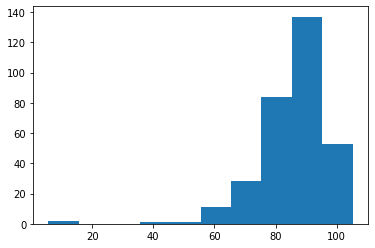

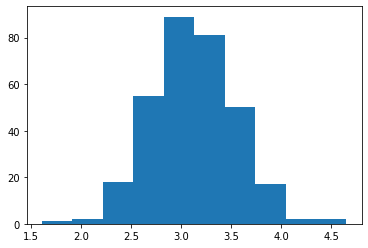

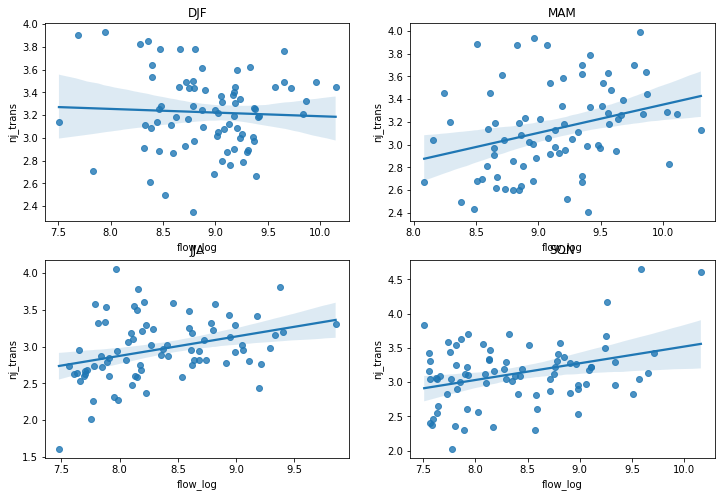

In [38]:
### residuals are pretty skewed, try transforming the original data
nj_trans_max = df_m['nj'].max()+5
df_m['nj_trans'] = np.log(nj_trans_max-df_m['nj'])

plt.figure()
plt.hist(df_m['nj'])

plt.figure()
plt.hist(df_m['nj_trans'])

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nj_trans'].loc[df_m['quarter'] == q], ax=ax)
    ax.set_title(q)
    

In [39]:
### get linear regression model for each quarter
import statsmodels.api as sm

lrms = {q: sm.OLS(df_m['nj_trans'].loc[df_m['quarter'] == q], 
                  sm.add_constant(df_m['flow_log'].loc[df_m['quarter'] == q])) for q in quarters}
lrrs = {q: lrms[q].fit() for q in quarters}
for q,lrr in lrrs.items():
    print(q)
    print(lrr.summary())

DJF
                            OLS Regression Results                            
Dep. Variable:               nj_trans   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1771
Date:                Thu, 13 Apr 2023   Prob (F-statistic):              0.675
Time:                        14:07:21   Log-Likelihood:                -25.929
No. Observations:                  79   AIC:                             55.86
Df Residuals:                      77   BIC:                             60.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5129      0.686      5.123     

<AxesSubplot:xlabel='flow_log', ylabel='Density'>

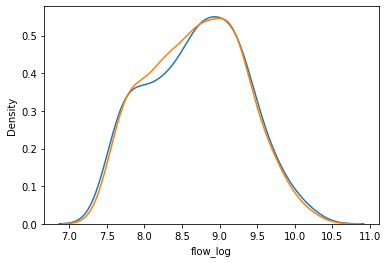

In [40]:
### now get longer dataset of flows for prediction
flow = pd.read_csv('input_data/catchment_inflow_obs_pub.csv', index_col=0)

flow.index = pd.to_datetime(flow.index)

df_long = pd.DataFrame({'flow_log':np.log(flow[trenton_catchments].sum(axis=1)), 'm':flow.index.month})
df_long_m = df_long.resample('m').mean()
df_long_m['quarter'] = [get_quarter(m) for m in df_long_m['m']]

sns.kdeplot(df_m['flow_log'])
sns.kdeplot(df_long_m['flow_log'])

In [41]:
### use trained regression model to sample an nyc delivery value for each month based on log flow. 
df_long_m['nj_trans_pred'] = 0.
for i in range(df_long_m.shape[0]):
    q = df_long_m['quarter'].iloc[i]
    f = df_long_m['flow_log'].iloc[i]
    lrm = lrms[q]
    lrr = lrrs[q]
    exog = lrm.exog
    exog[:, 1] = f
    ### get randomly sampled value from linear regression model. thrown out if negative
    pred = -1
    while pred < 0:
        pred = lrm.get_distribution(lrr.params, scale=np.var(lrr.resid), exog=exog).rvs()[0]
    df_long_m['nj_trans_pred'].iloc[i] = pred

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

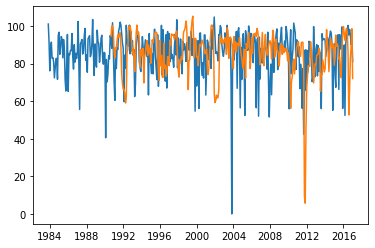

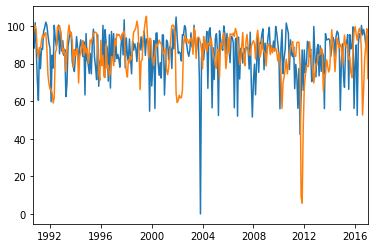

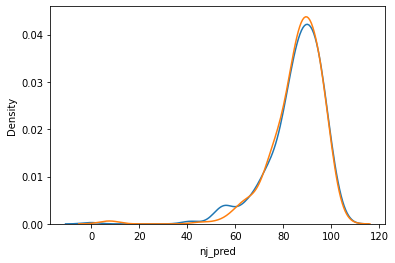

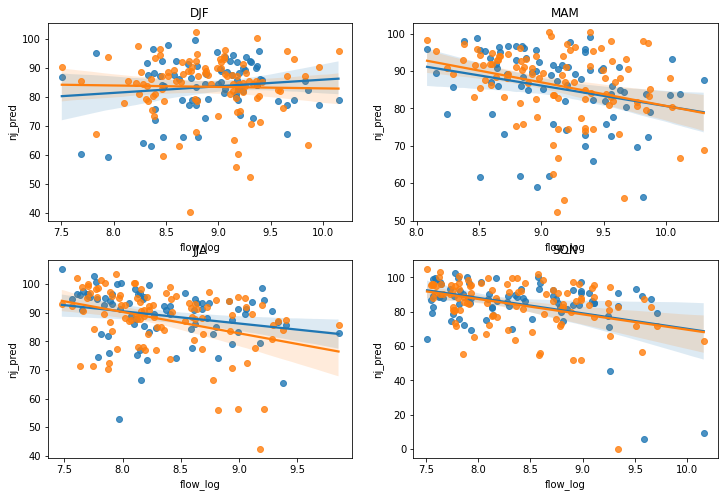

In [42]:
### transform back to original scale
df_long_m['nj_pred'] = np.maximum(nj_trans_max - np.exp(df_long_m['nj_trans_pred']), 0)

plt.figure()
plt.plot(df_long_m['nj_pred'])
plt.plot(df_m['nj'])

plt.figure()
plt.plot(df_long_m['nj_pred'])
plt.plot(df_m['nj'])
plt.xlim([df_m['nj'].index.min(), df_m['nj'].index.max()])

plt.figure()
sns.kdeplot(df_long_m['nj_pred'])
sns.kdeplot(df_m['nj'])

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nj'].loc[df_m['quarter'] == q], ax=ax)
    sns.regplot(df_long_m['flow_log'].loc[df_long_m['quarter'] == q], df_long_m['nj_pred'].loc[df_long_m['quarter'] == q], ax=ax)
    ax.set_title(q)

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:>

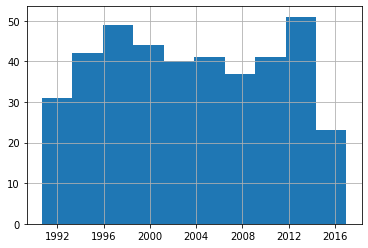

In [43]:
### now get nearest neighbor in normalized 2d space of log-flow/nj, within q.
flow_bounds = [df_m['flow_log'].min(), df_m['flow_log'].max()]
nj_bounds = [df_m['nj'].min(), df_m['nj'].max()]

df_m['flow_log_norm'] = (df_m['flow_log'] - flow_bounds[0]) / (flow_bounds[1] - flow_bounds[0])
df_m['nj_norm'] = (df_m['nj'] - nj_bounds[0]) / (nj_bounds[1] - nj_bounds[0])
df_long_m['flow_log_norm'] = (df_long_m['flow_log'] - flow_bounds[0]) / (flow_bounds[1] - flow_bounds[0])
df_long_m['nj_pred_norm'] = (df_long_m['nj_pred'] - nj_bounds[0]) / (nj_bounds[1] - nj_bounds[0])


df_long_m['nn'] = -1
for i in range(df_long_m.shape[0]):
    q = df_long_m['quarter'].iloc[i]
    f = df_long_m['flow_log_norm'].iloc[i]
    n = df_long_m['nj_pred_norm'].iloc[i]
    df_m_sub = df_m.loc[df_m['quarter'] == q]
    dist_squ = (f - df_m_sub['flow_log_norm']) **2 + (n - df_m_sub['nj_norm']) **2
    nn = np.argmin(dist_squ)
    df_long_m['nn'].iloc[i] = df_m_sub.index[nn]
df_long_m['nn'].hist()

In [44]:
### now use each month's nearest neighbor to get flow shape for nj_pred at daily time step
df_long['y'] = df_long.index.year
df_long_m['y'] = df_long_m.index.year
df['y'] = df.index.year
df_m['y'] = df_m.index.year
df['quarter'] = [get_quarter(m) for m in df['m']]
df_long['quarter'] = [get_quarter(m) for m in df_long['m']]

### iterate over months in longer record
df_long['nj_pred'] = -1
for i,row in df_long_m.iterrows():
    m = row['m']
    y = row['y']
    ### get the nj deliveries in nearest neighbor from shorter record
    df_long_idx = df_long.loc[np.logical_and(df_long['m'] == m, df_long['y'] == y)].index
    df_m_match = df_m.loc[row['nn']]
    df_match = df.loc[np.logical_and(df['m'] == df_m_match['m'], df['y'] == df_m_match['y'])]
    ### scale daily njs deliveries based on ratio of monthly prediction to match
    new_nj = df_match['nj'].values * row['nj_pred'] / df_m_match['nj']
    if np.any(new_nj < 0):
        print(row, new_nj)
    ### adjust based on length of month
    len_new = len(df_long_idx)
    len_match = len(new_nj)
    if len_match > len_new:
        new_nj = new_nj[:len_new]
    elif len_match < len_new:
        new_nj = np.append(new_nj, [new_nj[-1]]*(len_new - len_match))
    df_long['nj_pred'].loc[df_long_idx] = new_nj
    
df_long

/home/alh/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,flow_log,m,y,quarter,nj_pred
datetime,,,,,
1983-10-01,7.504279,10,1983,SON,97.651055
1983-10-02,7.602496,10,1983,SON,100.272560
1983-10-03,7.665017,10,1983,SON,100.927936
1983-10-04,7.658938,10,1983,SON,102.238688
1983-10-05,7.599265,10,1983,SON,100.272560
...,...,...,...,...,...
2016-12-27,8.251118,12,2016,DJF,85.199728
2016-12-28,8.242651,12,2016,DJF,85.199728
2016-12-29,8.261186,12,2016,DJF,85.199728


/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

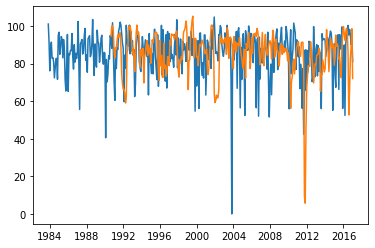

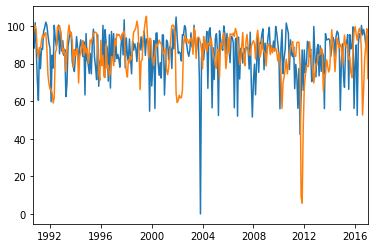

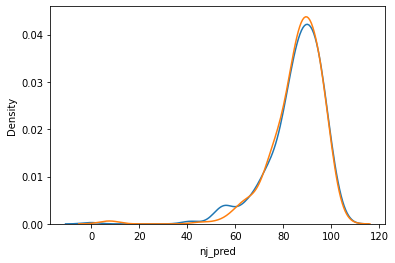

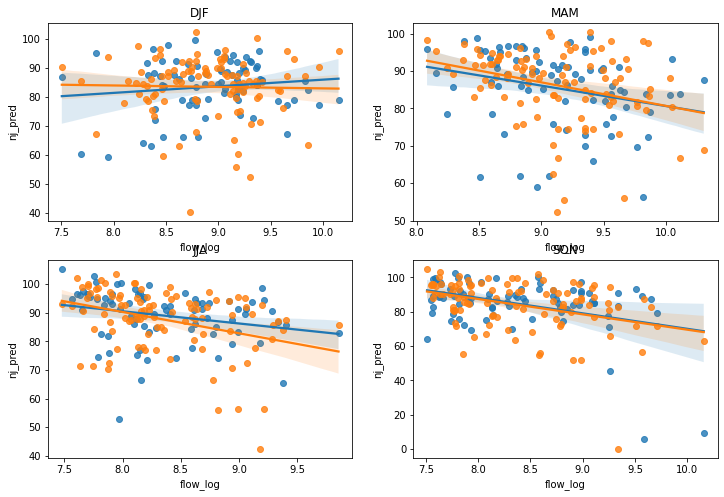

In [45]:
### viz monthly results
plt.figure()
plt.plot(df_long_m['nj_pred'])
plt.plot(df_m['nj'])

plt.figure()
plt.plot(df_long_m['nj_pred'])
plt.plot(df_m['nj'])
plt.xlim([df_m['nj'].index.min(), df_m['nj'].index.max()])

plt.figure()
sns.kdeplot(df_long_m['nj_pred'])
sns.kdeplot(df_m['nj'])

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df_m['flow_log'].loc[df_m['quarter'] == q], df_m['nj'].loc[df_m['quarter'] == q], ax=ax)
    sns.regplot(df_long_m['flow_log'].loc[df_long_m['quarter'] == q], df_long_m['nj_pred'].loc[df_long_m['quarter'] == q], ax=ax)
    ax.set_title(q)

/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alh/.local

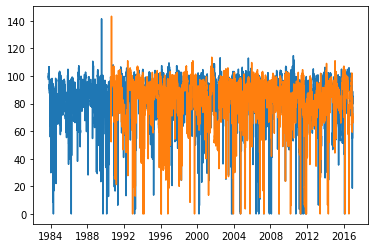

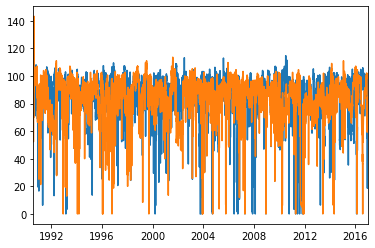

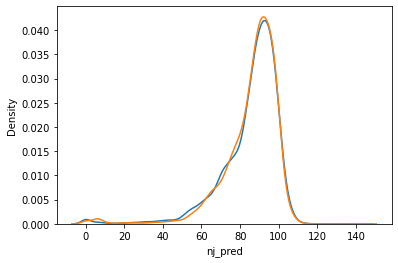

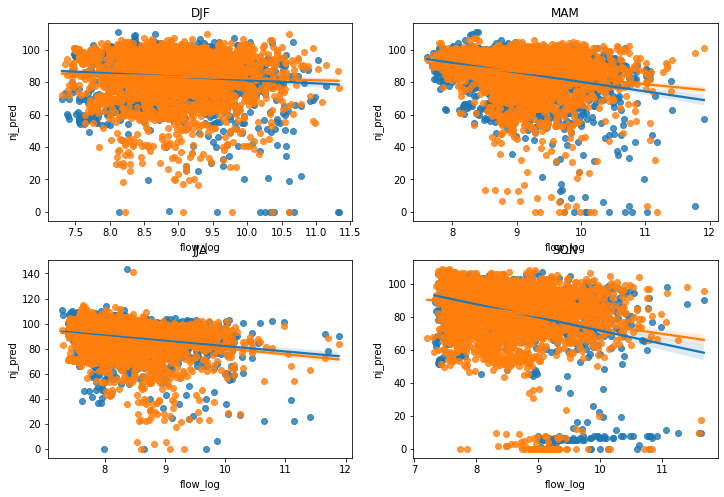

In [46]:
### viz daily results
plt.figure()
plt.plot(df_long['nj_pred'])
plt.plot(df['nj'])

plt.figure()
plt.plot(df_long['nj_pred'])
plt.plot(df['nj'])
plt.xlim([df['nj'].index.min(), df['nj'].index.max()])

plt.figure()
sns.kdeplot(df_long['nj_pred'])
sns.kdeplot(df['nj'])

fig,axs = plt.subplots(2,2, figsize=(12,8))
row = 0
col = 0
for i,q in enumerate(quarters):
    if i >= 2:
        row = 1
    if i%2 == 1:
        col = 1
    else:
        col = 0
    ax = axs[row,col]
    sns.regplot(df['flow_log'].loc[df['quarter'] == q], df['nj'].loc[df['quarter'] == q], ax=ax)
    sns.regplot(df_long['flow_log'].loc[df_long['quarter'] == q], df_long['nj_pred'].loc[df_long['quarter'] == q], ax=ax)
    ax.set_title(q)

In [47]:
### Ok now reload full NJ data, & replace predicted with actual data for time periods we have
nj = pd.read_csv('input_data/deliveryNJ_WEAP_23Aug2022_gridmet.csv', index_col=0)
nj.index = pd.to_datetime(nj.index)

df_long = df_long.loc[df_long.index < nj.index.min()]
nj = nj.append(pd.DataFrame({'D_R_Canal': df_long['nj_pred']}))
nj = nj.sort_index()
nj['datetime'] = nj.index
nj = nj.iloc[:, [-1,0]]
nj.to_csv('input_data/deliveryNJ_WEAP_23Aug2022_gridmet_extrapolated.csv', index=False)
nj

,datetime,D_R_Canal
datetime,,
1983-10-01,1983-10-01,97.651055
1983-10-02,1983-10-02,100.272560
1983-10-03,1983-10-03,100.927936
1983-10-04,1983-10-04,102.238688
1983-10-05,1983-10-05,100.272560
...,...,...
2022-05-28,2022-05-28,67.176966
2022-05-29,2022-05-29,94.952058
2022-05-30,2022-05-30,97.535788


### load in sampled version from prep_input_data.py to make sure everything looks right

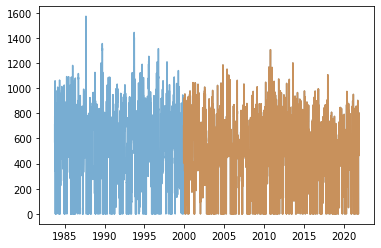

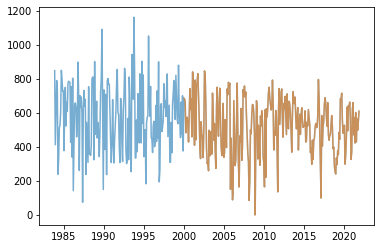

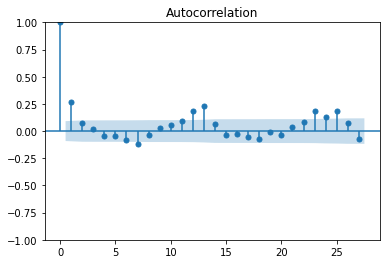

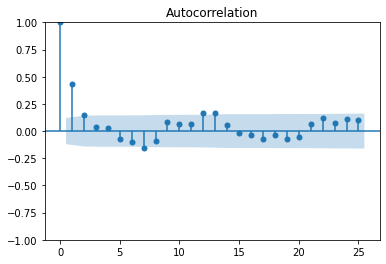

In [62]:
## read in historical NYC diversions from sharepoint
nyc = pd.read_excel('input_data/historical_diversions/Pep_Can_Nev_diversions_daily_2000-2021.xlsx', index_col=0)
nyc = nyc.iloc[:,:3]
nyc.index = pd.to_datetime(nyc.index)
nyc['aggregate'] = nyc.sum(axis=1)
### convert CFS to MGD
nyc *= 0.64631689

### read in newly created data
nyc_ext = pd.read_csv('input_data/deliveryNYC_ODRM_extrapolated.csv')
nyc_ext.index=pd.to_datetime(nyc_ext['datetime'])


plt.figure()
plt.plot(nyc_ext['aggregate'], alpha=0.6)
plt.plot(nyc['aggregate'], alpha=0.6)

plt.figure()
plt.plot(nyc_ext['aggregate'].resample('m').mean(), alpha=0.6)
plt.plot(nyc['aggregate'].resample('m').mean(), alpha=0.6)

_ = tsaplots.plot_acf(nyc_ext['aggregate'].resample('m').mean())
_ = tsaplots.plot_acf(nyc['aggregate'].resample('m').mean())

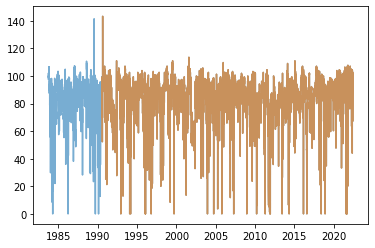

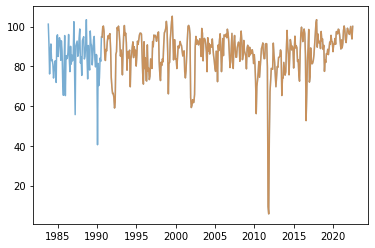

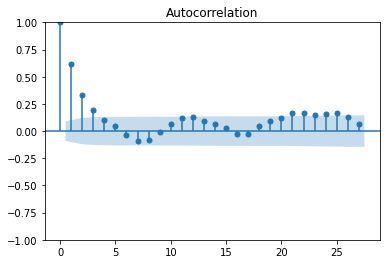

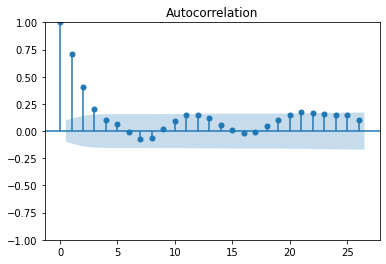

In [63]:
## read in historical NYC diversions from sharepoint
nj = pd.read_csv('input_data/deliveryNJ_WEAP_23Aug2022_gridmet.csv', index_col=0)
nj.index = pd.to_datetime(nj.index)

### read in newly created data
nj_ext = pd.read_csv('input_data/deliveryNJ_WEAP_23Aug2022_gridmet_extrapolated.csv')
nj_ext.index=pd.to_datetime(nj_ext['datetime'])


plt.figure()
plt.plot(nj_ext['D_R_Canal'], alpha=0.6)
plt.plot(nj['D_R_Canal'], alpha=0.6)

plt.figure()
plt.plot(nj_ext['D_R_Canal'].resample('m').mean(), alpha=0.6)
plt.plot(nj['D_R_Canal'].resample('m').mean(), alpha=0.6)

_ = tsaplots.plot_acf(nj_ext['D_R_Canal'].resample('m').mean())
_ = tsaplots.plot_acf(nj['D_R_Canal'].resample('m').mean())